# Importing the Libraries

In [19]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the relevant files
train_file = '../../Data/NCBItrainset_corpus.txt'
dev_file = '../../Data/NCBIdevelopset_corpus.txt'
model_name = '../../Models/BiLSTM_CrossAttention_NER_model.pth'


# Data Preparation

In [20]:
# Reading and parsing the dataset file
def read_dataset(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

def parse_dataset(lines):
    paragraphs, paragraph = [], []
    for line in lines:
        line = line.strip()
        if line:
            paragraph.append(line)
        else:
            if paragraph:
                paragraphs.append(paragraph)
                paragraph = []
    if paragraph:
        paragraphs.append(paragraph)
    return paragraphs

In [21]:
def parse_paragraph(paragraph):
    sentences, annotations, sentence = [], [], []
    for line in paragraph:
        if re.match(r'^\d+\|\w\|', line):
            sentence.extend(line.split('|')[2].split())
        elif re.match(r'^\d+\t\d+\t\d+\t', line):
            start, end = int(line.split("\t")[1]), int(line.split("\t")[2])
            annotations.append((start, end, line.split("\t")[3], line.split("\t")[4]))
    if sentence:
        sentences.append(sentence)
    return sentences, annotations

## Tagging the words based on character limits

In [22]:
def tag_annotations(sentences, annotations):
    tagged_sentences = []
    for sentence in sentences:
        tags = ['O'] * len(sentence)
        word_starts, word_ends, char_pos = [], [], 0
        for word in sentence:
            word_starts.append(char_pos)
            char_pos += len(word)
            word_ends.append(char_pos)
            char_pos += 1
        for start, end, _, label in annotations:
            for i, (word_start, word_end) in enumerate(zip(word_starts, word_ends)):
                if word_start >= start and word_end <= end:
                    tags[i] = 'I-' + label
                elif word_start < start < word_end or word_start < end < word_end:
                    tags[i] = 'I-' + label
        tagged_sentences.append((sentence, tags))
    return tagged_sentences

In [23]:
# Prepare the data
lines = read_dataset(train_file)
paragraphs = parse_dataset(lines)
all_sentences, all_tags = [], []
for paragraph in paragraphs:
    s, a = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(s, a)
    for sentence, tag in tagged_sentences:
        all_sentences.append(sentence)
        all_tags.append(tag)

# Prepare development data
dev_lines = read_dataset(dev_file)
dev_paragraphs = parse_dataset(dev_lines)
dev_sentences, dev_tags = [], []
for paragraph in dev_paragraphs:
    s, a = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(s, a)
    for sentence, tag in tagged_sentences:
        dev_sentences.append(sentence)
        dev_tags.append(tag)


In [24]:
class LSTM_Attention_NERDataset(Dataset):
    def __init__(self, sentences, tags, word_encoder, tag_encoder, unknown_token='<UNK>'):
        self.sentences = sentences
        self.tags = tags
        self.word_encoder = word_encoder
        self.tag_encoder = tag_encoder
        self.unknown_token = unknown_token

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]
        sentence_encoded = [self.word_encoder.get(word, self.word_encoder[self.unknown_token]) for word in sentence]
        tags_encoded = self.tag_encoder.transform(tags)
        return torch.tensor(sentence_encoded), torch.tensor(tags_encoded, dtype=torch.long)


In [25]:
all_words = [word for sentence in all_sentences for word in sentence]
all_tags_flat = [tag for tags in all_tags for tag in tags]

word_encoder = {word: idx for idx, word in enumerate(set(all_words))}
unknown_token = '<UNK>'
word_encoder[unknown_token] = len(word_encoder)

tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags_flat)

dataset = LSTM_Attention_NERDataset(all_sentences, all_tags, word_encoder, tag_encoder, unknown_token)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)


# Cross Attention Class Definition

In [26]:
class CrossAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.key = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value):
        query_proj = self.query(query)
        key_proj = self.key(key)
        value_proj = self.value(value)
        attention_scores = torch.matmul(query_proj, key_proj.transpose(-2, -1))
        attention_weights = self.softmax(attention_scores)
        context = torch.matmul(attention_weights, value_proj)
        return context


In [27]:
class BiLSTM_CrossAttention_NER_Model(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=128):
        super(BiLSTM_CrossAttention_NER_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.cross_attention = CrossAttention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x):
        emb = self.embedding(x)
        bilstm_out, _ = self.bilstm(emb)
        cross_att_out = self.cross_attention(bilstm_out, bilstm_out, bilstm_out)
        tag_space = self.fc(cross_att_out)
        return tag_space

# Training Model Parameters

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM_CrossAttention_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()

### Graph Plotting Function

In [29]:
# Function for plotting (to be used to visualize the training loss and validation loss)
# Used to figure if the mdoel is underfitting or overfitting
def graph_plot(title, x_label, y_label, x_data, y_data, color = 'blue', linestyle = '-'):
    plt.plot(x_data, y_data, color = color, linestyle = linestyle)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

# Training the Model

Epoch 1, Loss: 0.6539
Epoch 2, Loss: 0.3561
Epoch 3, Loss: 0.3110
Epoch 4, Loss: 0.2779
Epoch 5, Loss: 0.2464
Epoch 6, Loss: 0.2113
Epoch 7, Loss: 0.1827
Epoch 8, Loss: 0.1631
Epoch 9, Loss: 0.1470
Epoch 10, Loss: 0.1353
Epoch 11, Loss: 0.1267
Epoch 12, Loss: 0.1171
Epoch 13, Loss: 0.1077
Epoch 14, Loss: 0.0971
Epoch 15, Loss: 0.0886
Epoch 16, Loss: 0.0825
Epoch 17, Loss: 0.0738
Epoch 18, Loss: 0.0655
Epoch 19, Loss: 0.0596
Epoch 20, Loss: 0.0531
Epoch 21, Loss: 0.0481
Epoch 22, Loss: 0.0417
Epoch 23, Loss: 0.0369
Epoch 24, Loss: 0.0312
Epoch 25, Loss: 0.0282
Epoch 26, Loss: 0.0229
Epoch 27, Loss: 0.0204
Epoch 28, Loss: 0.0192
Epoch 29, Loss: 0.0170
Epoch 30, Loss: 0.0156
Epoch 31, Loss: 0.0129
Epoch 32, Loss: 0.0119
Epoch 33, Loss: 0.0109
Epoch 34, Loss: 0.0093
Epoch 35, Loss: 0.0085
Epoch 36, Loss: 0.0095
Epoch 37, Loss: 0.0087
Epoch 38, Loss: 0.0068
Epoch 39, Loss: 0.0073
Epoch 40, Loss: 0.0072


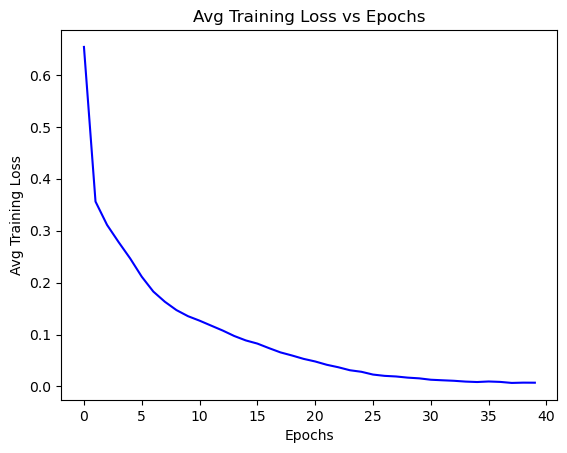

In [30]:
# Storing the Average training losses
loss_dic = {}

# Training the Model
for epoch in range(40):
    model.train()
    total_loss = 0
    for batch in dataloader:
        sentences, tags = zip(*batch)
        sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
        tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(sentences)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)
            loss = criterion(outputs, tags)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(dataloader)
    scheduler.step(avg_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss:.4f}")
    loss_dic[epoch] = avg_train_loss

graph_plot("Avg Training Loss vs Epochs", "Epochs", "Avg Training Loss", list(loss_dic.keys()), list(loss_dic.values()))

In [31]:
# Saving the model
torch.save(model.state_dict(), model_name)

# Testing the Model

In [32]:
# Testing the model, and evaluating the f1 score
test_file = '../../Data/NCBItestset_corpus.txt'
test_lines = read_dataset(test_file)
test_paragraphs = parse_dataset(test_lines)

In [33]:
# Parsing and storing the test dataset
test_sentences = []
test_tags = []

for paragraph in test_paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        test_sentences.append(sentence)
        test_tags.append(tags)

In [34]:
# Importing the model file
model = BiLSTM_CrossAttention_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
model.load_state_dict(torch.load(model_name))
model.eval()

BiLSTM_CrossAttention_NER_Model(
  (embedding): Embedding(14805, 128)
  (bilstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (cross_attention): CrossAttention(
    (query): Linear(in_features=256, out_features=256, bias=False)
    (key): Linear(in_features=256, out_features=256, bias=False)
    (value): Linear(in_features=256, out_features=256, bias=False)
    (softmax): Softmax(dim=-1)
  )
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [35]:
# Prepare the test data
test_dataset = LSTM_Attention_NERDataset(test_sentences, test_tags, word_encoder, tag_encoder, '<UNK>')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: x)

# Evaluate the model
all_true_labels = []
all_pred_labels = []

result = "../../Result/TestResults_CrossAttention_BiLSTM_NER.txt"
with open(result, 'w') as t_file:
    with torch.no_grad():
        for batch in test_dataloader:
            sentences, tags = zip(*batch)
            sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

            outputs = model(sentences)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)

            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            true_labels = tags.cpu().numpy()

            mask = true_labels != -100
            pred_labels = predictions[mask]
            true_labels = true_labels[mask]

            pred_labels_decoded = tag_encoder.inverse_transform(pred_labels)
            true_labels_decoded = tag_encoder.inverse_transform(true_labels)

            for true_label, pred_label in zip(true_labels_decoded, pred_labels_decoded):
                t_file.write(f'True: {true_label}, Pred: {pred_label}\n')
                all_true_labels.append(true_label)
                all_pred_labels.append(pred_label)

# Printing classification report
report = classification_report(all_true_labels, all_pred_labels)
print (report)

                    precision    recall  f1-score   support

I-CompositeMention       0.61      0.16      0.25        89
    I-DiseaseClass       0.47      0.48      0.48       255
        I-Modifier       0.74      0.59      0.66       367
 I-SpecificDisease       0.74      0.56      0.64      1090
                 O       0.97      0.99      0.98     18601

          accuracy                           0.95     20402
         macro avg       0.71      0.56      0.60     20402
      weighted avg       0.95      0.95      0.95     20402

